In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle

from statsmodels.tsa.seasonal import MSTL
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_pinball_loss

import data_prepro as data_prepro

In [ ]:
from importlib import reload
reload(data_prepro)

In [30]:
# import csv file
df = pd.read_csv('./data/2012-04-25_2024-01-25_KA_bike_weather.csv')

# change date col to datetime
df['date'] = pd.to_datetime(df['date'])
# set index as timestamp_CET but keep col
df.set_index('date', inplace=True, drop=False)
# rename date to timestamp_CET
df.rename(columns={'date': 'timestamp_CET'}, inplace=True)

print(df.info())
print(df.columns)
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4291 entries, 2012-04-25 to 2024-01-25
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp_CET   4291 non-null   datetime64[ns]
 1   bike_count      4291 non-null   float64       
 2   temperature     4291 non-null   float64       
 3   humidity        4291 non-null   float64       
 4   windspeed       4291 non-null   float64       
 5   wind_direction  4291 non-null   float64       
 6   visibility      4291 non-null   float64       
 7   precipitation   4291 non-null   float64       
 8   sun             4291 non-null   int64         
 9   windspeed_max   4291 non-null   float64       
 10  precip_indic    4291 non-null   float64       
 11  precip_type     4291 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 435.8 KB
None
Index(['timestamp_CET', 'bike_count', 'temperature', 'humidity', 'wind

,timestamp_CET,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
date,,,,,,,,,,,,
2024-01-21,2024-01-21,994.0,-1.500000,87.666667,1.587500,187.500000,14942.500000,0.0,191,7.7,0.0,0.0
2024-01-22,2024-01-22,3398.0,7.479167,76.791667,7.075000,223.750000,47245.416667,5.4,0,18.0,1.0,6.0
2024-01-23,2024-01-23,4427.0,8.358333,74.541667,7.250000,231.250000,38257.916667,0.5,164,16.6,0.5,3.0
2024-01-24,2024-01-24,4124.0,11.945833,72.291667,8.350000,234.583333,45765.833333,1.9,7,18.8,0.0,0.0
2024-01-25,2024-01-25,4594.0,9.366667,85.083333,3.345833,229.583333,23374.583333,1.0,220,7.5,0.0,0.0


In [ ]:
# - - - - - - - - - - 
# further params
quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]
weather_cols = ['temperature', 'humidity', 'windspeed', 'wind_direction', 'windspeed_max',
                'visibility', 'sun', 'precipitation', 'precip_indic', 'precip_type']

### Random Forest

In [14]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [40]:
train_size = 0.99
test_size = 1 - train_size

df_train = df.iloc[:int(len(df)*train_size)]
df_test = df.iloc[int(len(df)*train_size):]

# = = = = = = = = = = = = = = =
# TRAIN DATA
df_dummy = data_prepro.create_dummy_df(df_train, holiday_method='separate', school_holidays_bw=True)
X_train_dummy = df_dummy.drop(columns=['bike_count', 'timestamp_CET'])
y_train_dummy = df_dummy['bike_count']

df_features = data_prepro.create_features_df(df_train, holiday_method='separate', school_holidays_bw=True)
X_train_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET'])
y_train_fturs = df_features['bike_count']

# = = = = = = = = = = = = = = =
# TEST DATA
X_test_dummy = data_prepro.create_dummy_df(df_test, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])
X_test_fturs = data_prepro.create_features_df(df_test, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])

y_test = df_test['bike_count']

In [43]:
model_params_fit_not_done = False

if model_params_fit_not_done:

    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=4,
        n_jobs=-1,
    )
    cv_obj.fit(X_train_dummy, y_train_dummy)
    model = cv_obj.best_estimator_
    
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=9, n_estimators=95, random_state=59
    )

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [53]:
# max_dephts = [5, 10, 15, 20, 25, 30]
# n_estims = [50, 100, 150, 200, 250, 300]
# params = [(max_depht, n_estim) for max_depht in max_dephts for n_estim in n_estims]
# print(len(params))

# res_list = []

# for param_idx, param in enumerate(params):

#     print(f"param_idx = {param_idx}/{len(params)}", end='\r')
#     max_depth, n_estim = param
#     model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estim, random_state=59)

#     # fit model
#     model.fit(X_train_dummy, y_train_dummy)

#     # predict on test set
#     y_pred_insample = model.predict(X_train_dummy)
#     # metrics
#     # print('RMSE: ', np.sqrt(mean_squared_error(y_train_dummy, y_pred_insample)))
#     # print('MAE: ', mean_absolute_error(y_train_dummy, y_pred_insample))

#     # predict on test set
#     X_test = df[int(len(df)*train_size):].drop('bike_count', axis=1)
#     y_test = df['bike_count'][int(len(df)*train_size):]
#     y_pred = model.predict(X_test_dummy)

#     # plot predictions
#     # plt.figure(figsize=(15, 5))
#     # plt.plot(y_test, label='true')
#     # plt.plot(y_test.index, y_pred, label='pred')
#     # plt.legend()
#     # plt.show()

#     # print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
#     # print('MAE: ', mean_absolute_error(y_test, y_pred))

#     # save in dict
#     model_dict = {'max_depth': max_depth, 'n_estimators': n_estim, 
#                 'RMSE insample': np.sqrt(mean_squared_error(y_train_dummy, y_pred_insample)), 
#                 'MAE insample': mean_absolute_error(y_train_dummy, y_pred_insample), 
#                 'RMSE OOS': np.sqrt(mean_squared_error(y_test, y_pred)), 
#                 'MAE OOS': mean_absolute_error(y_test, y_pred)}
    
#     res_list.append(model_dict)

36


In [59]:
# make df
res_df = pd.DataFrame(res_list)
res_df.sort_values(by='RMSE OOS', inplace=True)
res_df.head()

,max_depth,n_estimators,RMSE insample,MAE insample,RMSE OOS,MAE OOS
20,20,150,370.645779,254.761006,543.136915,381.037767
26,25,150,324.633091,219.216943,543.453357,379.682090
27,25,200,323.890023,218.396847,545.426859,382.523422
29,25,300,324.553925,218.035792,546.401305,379.956801
21,20,200,369.505283,254.031061,546.503740,385.487938


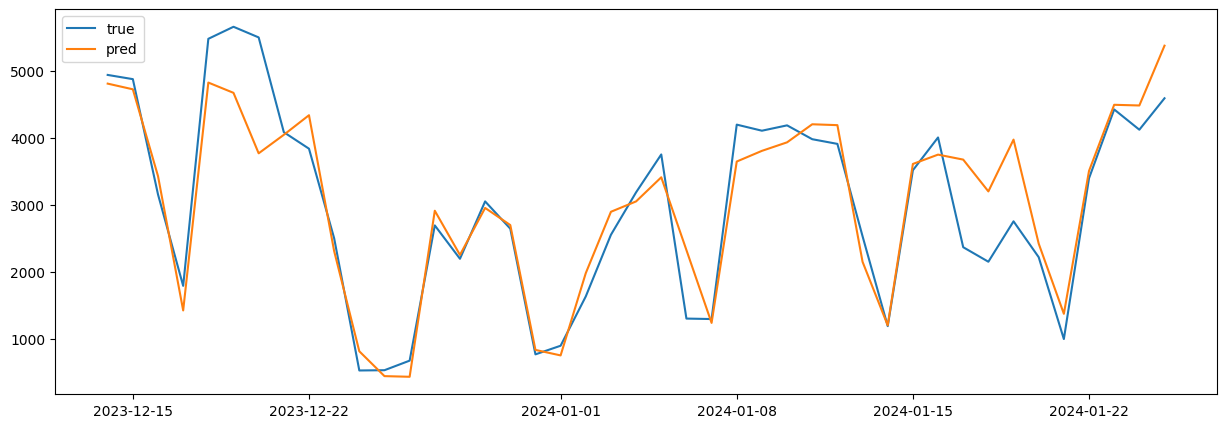

RMSE:  543.1369152774325
MAE:  381.03776676823225


In [61]:
model = RandomForestRegressor(max_depth=20, n_estimators=150, random_state=59)

# fit model
model.fit(X_train_dummy, y_train_dummy)

# predict on test set
y_pred_insample = model.predict(X_train_dummy)

# predict on test set
X_test = df[int(len(df)*train_size):].drop('bike_count', axis=1)
y_test = df['bike_count'][int(len(df)*train_size):]
y_pred = model.predict(X_test_dummy)

# plot predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='true')
plt.plot(y_test.index, y_pred, label='pred')
plt.legend()
plt.show()

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE: ', mean_absolute_error(y_test, y_pred))

### MAPIE (doesnt work ...)

In [62]:
# import warnings

# import numpy as np
# import pandas as pd
# from matplotlib import pylab as plt
# from scipy.stats import randint
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# from mapie.metrics import (regression_coverage_score,
#                            regression_mean_width_score,
#                            coverage_width_based)
                           
# from mapie.subsample import BlockBootstrap
# from mapie.regression import MapieTimeSeriesRegressor

In [66]:
# alpha = 0.05
# gap = 1
# cv_mapiets = BlockBootstrap(
#     n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
# )
# mapie_enbpi = MapieTimeSeriesRegressor(
#     model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
# )

# # For EnbPI
# mapie_enbpi = mapie_enbpi.fit(X_train_dummy, y_train_dummy)

# y_pred_enbpi_npfit, y_pis_enbpi_npfit = mapie_enbpi.predict(
#     X_test_dummy, alpha=alpha, ensemble=True, optimize_beta=True,
#     allow_infinite_bounds=True
# )

# y_pis_enbpi_npfit = np.clip(y_pis_enbpi_npfit, 1, 10)
# coverage_enbpi_npfit = regression_coverage_score(
#     y_test, y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
# )

# width_enbpi_npfit = regression_mean_width_score(
#     y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
# )

# cwc_enbpi_npfit = coverage_width_based(
#     y_test, y_pis_enbpi_npfit[:, 0, 0],
#     y_pis_enbpi_npfit[:, 1, 0],
#     eta=10,
#     alpha=0.05
# )

c:\Users\ytl_c\miniconda3\Lib\site-packages\mapie\utils.py:514: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
c:\Users\ytl_c\miniconda3\Lib\site-packages\mapie\aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)
c:\Users\ytl_c\miniconda3\Lib\site-packages\mapie\estimator\estimator.py:297: RuntimeWarning: invalid value encountered in divide
  return np.matmul(x, (K / (K.sum(axis=1, keepdims=True))).T)
c:\Users\ytl_c\miniconda3\Lib\site-packages\mapie\utils.py:598: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(
c:\Users\ytl_c\miniconda3\Lib\site-packages\mapie\utils.py:598: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


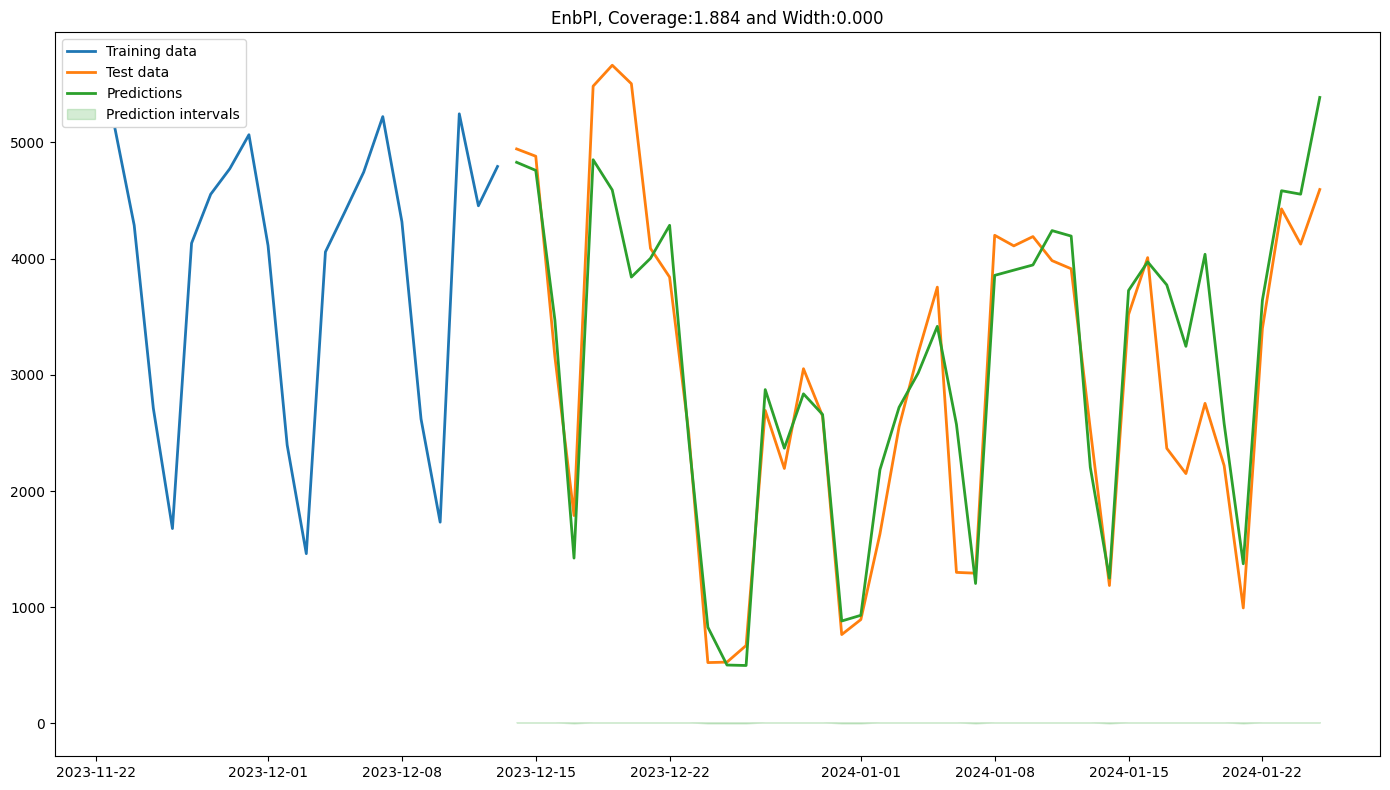

In [79]:
# y_train = y_train_dummy
# y_enbpi_preds = y_pred_enbpi_npfit
# y_enbpi_pis = y_pis_enbpi_npfit
# coverages_enbpi = width_enbpi_npfit
# widths_enbpi = cwc_enbpi_npfit

# fig, ax = plt.subplots(figsize=(14, 8))

# ax.plot(
#     y_train[int(-len(y_test)/2):],
#     lw=2,
#     label="Training data", c="C0"
# )
# ax.plot(y_test, lw=2, label="Test data", c="C1")

# ax.plot(
#     y_test.index, y_enbpi_preds, lw=2, c="C2", label="Predictions"
# )
# ax.fill_between(
#     y_test.index,
#     y_enbpi_pis[:, 0, 0],
#     y_enbpi_pis[:, 1, 0],
#     color="C2",
#     alpha=0.2,
#     label="Prediction intervals",
# )
# title = f"EnbPI, Coverage:{coverages_enbpi:.3f} and Width:{widths_enbpi:.3f}"

# ax.set_title(title)
# ax.legend()
# fig.tight_layout()
# plt.show()